### Imports

In [1]:
import sys
import json
import time
import requests
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

### Constants

In [2]:
SUBREDDIT = 'roastme'
SUBMISSION_KEY_WHITELIST = [
    'created_utc',
    'id',
    'num_comments',
    'url',
    'score',
    'title',
    'comments'
]

COMMENT_KEY_WHITELIST = [
    'body',
    'score', 
]

### Utilties

In [3]:
def gen_pushshift_submission_url(subreddit, timestamp):
    """
    Get pushshift request for 100 submissions from a specificed subreddit before a certain time
    
    Args:
        subreddit (str): name of subreddit to query
        timestamp: unix timestamp
        
    """
    return 'https://api.pushshift.io/reddit/submission/search/?subreddit={}&size=100&before={}'.format(subreddit, timestamp)

def gen_pushshift_comments_url(post_id, timestamp):
    return 'https://api.pushshift.io/reddit/comment/search/?link_id={}&limit=100&before={}'.format(post_id, timestamp)

def try_and_repeat(url, n=20, sleep=30, verbose=True):
    """
    Make a request and retry a specified number of times if it fails
    
    Args:
        url (str): request url
    Kwargs:
        n (int): Number of times to retry request. Default 20
        sleep (int): Seconds to wait between each request. Default 30
        verbose (boolean): Display status codes for failures. Default True
    """
    for i in range(n):
        response = requests.get(url)
        if response.status_code == 200: break
        if verbose: print('Failed {}, trying again...'.format(response.status_code))
        time.sleep(sleep)
        
    return response

def get_submissions(subreddit, n, min_comments=10, min_age=7, verbose=2):
    """
    Get N image submissions from a subreddit
    
    Args:
        subreddit (str): name of subreddit to query
        n (int): number of submissions to retrieve
    Kwargs:
        min_comments (int): Minimum number of comments a submission must have. Default 10.
        min_age (int): Minimum age of a submission in days. Default 7.
        verbose (int): Varying levels of intermediate output. Default 2.
        
    """
    all_data = []
    previous_epoch = int((datetime.utcnow() - timedelta(days=min_age)).timestamp())
    
    while len(all_data) < n:
        pushshift_endpoint = gen_pushshift_submission_url(subreddit, previous_epoch)
        if verbose > 1: print('requesting {}...'.format(pushshift_endpoint))
        response = try_and_repeat(pushshift_endpoint, verbose=verbose>1).json()
        
        if 'data' in response and len(response['data']) > 0:           
            data = response['data']
            data = filter_submissions(data, min_comments=min_comments)
            all_data.extend(data)
            previous_epoch = data[-1]['created_utc']
        else:
            if verbose > 0: print('No more posts before {}'.format(previous_epoch))
            break
        
    if verbose > 1: print('Retrieved posts: {}'.format(len(all_data)))
        
    return all_data

def get_comments(post_id, verbose=True):
    """
    Get commnets from a submission
    
    Args:
        post_id (str): post id for submission to retrieve comments from
    Kwargs:
        verbose (boolean): Display intermediate output. Default True
    """
    comment_data = []
    previous_epoch = int(datetime.utcnow().timestamp())

    while True:
        pushshift_endpoint = gen_pushshift_comments_url(post_id, previous_epoch)
        if verbose: print('requesting {}...'.format(pushshift_endpoint))
        response = try_and_repeat(pushshift_endpoint)
        response = requests.get(pushshift_endpoint).json()

        if 'data' in response and len(response['data']) > 0:
            data = response['data']
            data = filter_comments(data)
            comment_data.extend(data)
            previous_epoch = data[-1]['created_utc']
        else:
            break

    if verbose: print('Retrieved comments: {}'.format(len(comment_data)))
        
    return comment_data

def get_comments_from_submissions(submissions, verbose=2):
    """
    Retrieve all comments from a number of submissions
    
    Args:
        submissions (list): List of submissions
    Kwargs:
        verbose (int): Varying levels of intermediate output. Default 2.
    """
    for i, submission in enumerate(submissions):
        if verbose >1: print('{}/{}'.format(i+1, len(submissions)))
        post_id = submission['permalink'].split('/')[4]
        comments = get_comments(post_id, verbose=verbose)
        submission['comments'] = comments
        print()
        
    return submissions

def filter_submissions(submissions, min_comments=10, min_karma=0, exclude_meta=True):
    """
    Filter submissions by number of comments, karma and the type of post. Excludes videos,
    self posts and (some) deleted posts.
    
    Args:
        submissions (list): List of submissions to filter
    Kwargs:
        min_comments (int): minimum number of comments. Default 10
        min_karma (int): minimum amount of karma. Default 0
        exclude_meta (boolean): Exlcude posts tagged as meta. Default True
    """
    filtered = [
        submission 
        for submission in submissions
        if not (submission['num_comments'] < 10 or 
        submission['score'] < min_karma or 
        (submission['is_meta'] and exclude_meta) or 
        submission['is_video'] or 
        submission['is_self'] or
        submission['author'] == '[deleted]')
    ]
            
    return filtered

def filter_comments(comments, min_karma=0, min_body_length=5):
    """
    Filter comments by karma and the length.
    Args:
        comments (list): List of comments to filter
    Kwargs:
        min_karma (int): minimum amount of karma. Default 0
        min_body_length (boolean): Min character length of comment. Default 5
    """
    filtered = [
        comment 
        for comment in comments
        if not (comment['score'] < min_karma or 
        (comment['is_submitter'] and exclude_meta) or 
        len(comment['body']) < min_body_length or 
        comment['author'] == '[deleted]'
        or comment['parent_id'][:3] != 't3_')
    ]
            
    return filtered

def strip_bloat(submissions):
    """
    Strip unwanted fields from submissions and comments
    
    Args:
        submissions (list): List of submissions
    """
    stripped_submissions = []
    for submission in submissions:
        submission = {key: submission[key] for key in SUBMISSION_KEY_WHITELIST}
        submission['comments'] = [
            {key: comment[key] for key in COMMENT_KEY_WHITELIST} 
            for comment in submission['comments']
        ]
        stripped_submissions.append(submission)

    return stripped_submissions

### Get Posts

In [4]:
submissions = get_submissions(SUBREDDIT, n=1000)

requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1613001068...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1612884632...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1612799955...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1612426959...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1612347597...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1612245387...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1612170738...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1612084083...
requesting https://api.pushshift.io/reddit/submission/search/?subreddit=roastme&size=100&before=1611982134...
requesting

### Get Comments

In [5]:
submissions = get_comments_from_submissions(submissions)

1/1028
requesting https://api.pushshift.io/reddit/comment/search/?link_id=lh6j1o&limit=100&before=1613605992...


NameError: name 'exclude_meta' is not defined

### Strip Unessnesary Fields

In [ ]:
print('Submissions {} bytes'.format(sys.getsizeof(submissions)))
submissions = strip_bloat(submissions)
print('Submissions {} bytes'.format(sys.getsizeof(submissions)))

### Save Data

In [ ]:
with open('../data/raw_submissions_data_1000.json', 'w') as j:
    json.dump(submissions, j)

### Load Data

In [4]:
with open('../data/raw_submissions_data_100.json', 'r') as j:
    submissions = json.load(j)

### Analysis

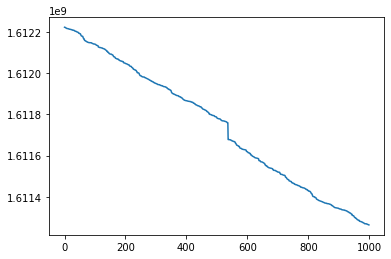

In [9]:
plt.plot([s['created_utc'] for s in submissions])

In [ ]:
plt.hist([s['score'] for s in submission_data])

In [18]:
sum([d['is_meta'] for d in all_data])

0

In [19]:
sum([d['is_video'] for d in all_data])

2

In [20]:
sum([d['is_self'] for d in all_data])

0